##**INSTALL REQUIRED PACKAGES AND IMPORT OTHERS**

In [ ]:
!pip install --upgrade geopandas shapely hyperopt scikit-learn
!pip install delayed

Requirement already up-to-date: geopandas in /usr/local/lib/python3.7/dist-packages (0.9.0)
Requirement already up-to-date: shapely in /usr/local/lib/python3.7/dist-packages (1.7.1)
Requirement already up-to-date: hyperopt in /usr/local/lib/python3.7/dist-packages (0.2.5)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import scale,normalize
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,accuracy_score,classification_report
import pickle
%matplotlib inline


## **COMBINE ALL TRAINING DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
list_data=[....]## the drive link
list_kab=[....]## id of municipality

In [ ]:
all_train=pd.DataFrame()
for i in range(0,len(list_data)):
  temp=pd.read_csv(list_data[i],sep=';').dropna()
  temp['idkab']=list_kab[i]
  all_train=temp[['Class_ID', 'xcoord', 'ycoord', 'L8_B2_min', 'L8_B3_min',
       'L8_B4_min', 'L8_B5_min', 'L8_B6_min', 'L8_B2_med', 'L8_B3_med',
       'L8_B4_med', 'L8_B5_med', 'L8_B6_med', 'L8_B2_mean', 'L8_B3_mean',
       'L8_B4_mean', 'L8_B5_mean', 'L8_B6_mean', 'L8_B2_stdev', 'L8_B3_stdev',
       'L8_B4_stdev', 'L8_B5_stdev', 'L8_B6_stdev', 'L8_bright_mean',
       'L8_green_mean', 'L8_wet_mean', 'L8_bright_med', 'L8_green_med',
       'L8_wet_med', 'S2_B2_min', 'S2_B3_min', 'S2_B4_min', 'S2_B8_min',
       'S2_B11_min', 'S2_B2_med', 'S2_B3_med', 'S2_B4_med', 'S2_B8_med',
       'S2_B11_med', 'S2_B2_mean', 'S2_B3_mean', 'S2_B4_mean', 'S2_B8_mean',
       'S2_B11_mean', 'S2_B2_stdev', 'S2_B3_stdev', 'S2_B4_stdev',
       'S2_B8_stdev', 'S2_B11_stdev', 'S2_bright_mean', 'S2_green_mean',
       'S2_wet_mean', 'S2_bright_med', 'S2_green_med', 'S2_wet_med',
       'S1_VV_min', 'S1_VH_min', 'S1_VV_med', 'S1_VH_med', 'S1_VV_mean',
       'S1_VH_mean', 'S1_ration_med', 'S1_ratio_mean', 'S1_ratio_min',
       'Alos_dsm', 'Alos_slope', 'Alos_landform','idkab']].append(all_train)

DESKRIPSI CLASS ID

In [ ]:
all_train.pivot_table(values='xcoord',index='idkab',columns='Class_ID',aggfunc='count').fillna(0)

Class_ID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
idkab,,,,,,,,,,,
3205,21028.0,9224.0,1728.0,6064.0,6831.0,0.0,842.0,0.0,4641.0,0.0,6222.0
3213,2232.0,436.0,5153.0,429.0,0.0,0.0,0.0,0.0,2564.0,0.0,4083.0
3271,720.0,1716.0,1113.0,210.0,1802.0,0.0,463.0,168.0,1638.0,0.0,52.0
3272,3607.0,3187.0,1170.0,2783.0,8518.0,0.0,159.0,231.0,4128.0,32.0,235.0
3315,367.0,441.0,78.0,75.0,0.0,0.0,0.0,43.0,115.0,0.0,0.0
3329,2492.0,4970.0,0.0,281.0,651.0,0.0,0.0,188.0,1982.0,0.0,10064.0
3376,164.0,106.0,9.0,17.0,6.0,14.0,0.0,52.0,412.0,0.0,1523.0
3674,13.0,99.0,48.0,0.0,20.0,0.0,35.0,67.0,402.0,0.0,20.0


## **DATA TRANSFORMATION**
- Transform the ALOS landform into PODES landform categoric

In [ ]:
dict_data_landform={0:'others',11:'others',12:'others',14:'others',15:'others',21: 'u-slope',22:'u-slope',
                   31:'l-slope',32:'l-slope',41:'valley',42:'valley',24:'flat',34:'flat'}
all_train['PODES_landform']=all_train['Alos_landform'].apply(lambda y: dict_data_landform[y])
cat_data=pd.get_dummies(all_train[['PODES_landform']], columns=['PODES_landform'], prefix=["Type_is"])

In [ ]:
all_train=all_train.join(cat_data)

## **TUNING AND FEATURE SELECTION**

### Mutual Information

In [ ]:
mi_=mutual_info_classif(all_train[[ 'L8_B2_min', 'L8_B3_min',
       'L8_B4_min', 'L8_B5_min', 'L8_B6_min', 'L8_B2_med', 'L8_B3_med',
       'L8_B4_med', 'L8_B5_med', 'L8_B6_med', 'L8_B2_mean', 'L8_B3_mean',
       'L8_B4_mean', 'L8_B5_mean', 'L8_B6_mean', 'L8_B2_stdev', 'L8_B3_stdev',
       'L8_B4_stdev', 'L8_B5_stdev', 'L8_B6_stdev', 'L8_bright_mean',
       'L8_green_mean', 'L8_wet_mean', 'L8_bright_med', 'L8_green_med',
       'L8_wet_med', 'S2_B2_min', 'S2_B3_min', 'S2_B4_min', 'S2_B8_min',
       'S2_B11_min', 'S2_B2_med', 'S2_B3_med', 'S2_B4_med', 'S2_B8_med',
       'S2_B11_med', 'S2_B2_mean', 'S2_B3_mean', 'S2_B4_mean', 'S2_B8_mean',
       'S2_B11_mean', 'S2_B2_stdev', 'S2_B3_stdev', 'S2_B4_stdev',
       'S2_B8_stdev', 'S2_B11_stdev', 'S2_bright_mean', 'S2_green_mean',
       'S2_wet_mean', 'S2_bright_med', 'S2_green_med', 'S2_wet_med',
       'S1_VV_min', 'S1_VH_min', 'S1_VV_med', 'S1_VH_med', 'S1_VV_mean',
       'S1_VH_mean', 'S1_ration_med', 'S1_ratio_mean', 'S1_ratio_min',
       'Alos_dsm', 'Alos_slope',
       'Type_is_flat', 'Type_is_l-slope', 'Type_is_others', 'Type_is_u-slope',
       'Type_is_valley']],all_train['Class_ID'])

In [ ]:
mi_

array([0.63768711, 0.59914814, 0.74670432, 0.65976699, 0.83559187,
       0.55554876, 0.55775694, 0.67152822, 0.69253676, 0.92300003,
       0.36390052, 0.33872573, 0.4307244 , 0.71428539, 0.86841466,
       0.33737009, 0.34690172, 0.40046756, 0.44552971, 0.36978081,
       0.65288398, 0.65520799, 0.49114441, 0.84383407, 0.71483373,
       0.55718173, 0.66772911, 0.64382858, 0.69387634, 0.43978033,
       0.42958851, 0.59708328, 0.59104368, 0.58303663, 0.588081  ,
       0.36869372, 0.58715748, 0.58559565, 0.61119699, 0.62694955,
       0.38531364, 0.5244612 , 0.53780579, 0.60330874, 0.4634114 ,
       0.42074463, 0.18663949, 0.14533616, 0.0969143 , 0.23264749,
       0.18199357, 0.09837051, 0.61695754, 0.52011621, 0.66881147,
       0.59866304, 0.67635717, 0.61155501, 0.22615017, 0.2766502 ,
       0.18843576, 0.63095473, 0.29668702, 0.00415814, 0.00262547,
       0.00376318, 0.00400273, 0.00249777])

From the result, we must set the border value of accepted features. Eg: 0.6 as borderline (Because the problem is multiclass, it's difficult to get mutual information over 0.8)

In [ ]:
data_col=[ 'L8_B2_min', 'L8_B3_min',
       'L8_B4_min', 'L8_B5_min', 'L8_B6_min', 'L8_B2_med', 'L8_B3_med',
       'L8_B4_med', 'L8_B5_med', 'L8_B6_med', 'L8_B2_mean', 'L8_B3_mean',
       'L8_B4_mean', 'L8_B5_mean', 'L8_B6_mean', 'L8_B2_stdev', 'L8_B3_stdev',
       'L8_B4_stdev', 'L8_B5_stdev', 'L8_B6_stdev', 'L8_bright_mean',
       'L8_green_mean', 'L8_wet_mean', 'L8_bright_med', 'L8_green_med',
       'L8_wet_med', 'S2_B2_min', 'S2_B3_min', 'S2_B4_min', 'S2_B8_min',
       'S2_B11_min', 'S2_B2_med', 'S2_B3_med', 'S2_B4_med', 'S2_B8_med',
       'S2_B11_med', 'S2_B2_mean', 'S2_B3_mean', 'S2_B4_mean', 'S2_B8_mean',
       'S2_B11_mean', 'S2_B2_stdev', 'S2_B3_stdev', 'S2_B4_stdev',
       'S2_B8_stdev', 'S2_B11_stdev', 'S2_bright_mean', 'S2_green_mean',
       'S2_wet_mean', 'S2_bright_med', 'S2_green_med', 'S2_wet_med',
       'S1_VV_min', 'S1_VH_min', 'S1_VV_med', 'S1_VH_med', 'S1_VV_mean',
       'S1_VH_mean', 'S1_ration_med', 'S1_ratio_mean', 'S1_ratio_min',
       'Alos_dsm', 'Alos_slope',
       'Type_is_flat', 'Type_is_l-slope', 'Type_is_others', 'Type_is_u-slope',
       'Type_is_valley']
col_mi=[data_col[i] for i in list(np.where(mi_>.6)[0])]
print(len(col_mi))
print(col_mi)

24
['L8_B2_min', 'L8_B4_min', 'L8_B5_min', 'L8_B6_min', 'L8_B4_med', 'L8_B5_med', 'L8_B6_med', 'L8_B5_mean', 'L8_B6_mean', 'L8_bright_mean', 'L8_green_mean', 'L8_bright_med', 'L8_green_med', 'S2_B2_min', 'S2_B3_min', 'S2_B4_min', 'S2_B4_mean', 'S2_B8_mean', 'S2_B4_stdev', 'S1_VV_min', 'S1_VV_med', 'S1_VV_mean', 'S1_VH_mean', 'Alos_dsm']


### Tuning standard parameter for Random Forest

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
space4rf_1 = {
    'max_features': hp.uniform('max_features', 0.05,1),
    'n_estimators': hp.choice('n_estimators', [20,50,100]),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'max_depth': hp.choice('max_depth', [5,10,15,20,None]),
    'class_weight':hp.choice('class_weight',['balanced','balanced_subsample']),
    'min_samples_split':hp.uniform('min_samples_split',0.00002,0.0005),
    'min_samples_leaf':hp.uniform('min_samples_leaf',0.00002,0.0005),
    'min_impurity_decrease':hp.uniform('min_impurity_decrease',0.0001,0.03)}
columns=col_mi
X=all_train[col_mi]
y=all_train['Class_ID']
def hyperopt_train_test(params):
    X_ = X[:]
    st_kfold=StratifiedKFold(n_splits=10)
    clf = RandomForestClassifier(random_state=1234,n_jobs=-1,oob_score = True,bootstrap=True, **params)
    return cross_val_score(clf, X_, y,scoring='f1_weighted',cv=st_kfold).mean()
best= 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf_1, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:',best)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few

new best:
0.8084611853675796
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.14983904451743044, 'min_impurity_decrease': 0.002368351145317672, 'min_samples_leaf': 0.0004554203759603965, 'min_samples_split': 0.0003765323732039089, 'n_estimators': 20}
 10%|█         | 1/10 [01:40<15:07, 100.87s/trial, best loss: -0.8084611853675796]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few

new best:
0.8084611853675796
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 0.8156878638371501, 'min_impurity_decrease': 0.0036813613721687457, 'min_samples_leaf': 0.0002791010973398932, 'min_samples_split': 0.00022209303882654834, 'n_estimators': 20}
 20%|██        | 2/10 [05:53<19:30, 146.28s/trial, best loss: -0.8084611853675796]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few

new best:
0.8084611853675796
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.8850985198610224, 'min_impurity_decrease': 0.01079788464864933, 'min_samples_leaf': 0.0003375087905947727, 'min_samples_split': 0.00040763748971031605, 'n_estimators': 20}
 30%|███       | 3/10 [10:07<20:50, 178.66s/trial, best loss: -0.8084611853675796]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



new best:
0.8084611853675796
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.5200555717195199, 'min_impurity_decrease': 0.0031258325707957534, 'min_samples_leaf': 0.0003472187894010576, 'min_samples_split': 0.00021795757075654065, 'n_estimators': 100}
new best:
0.8084611853675796
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.7861591482686721, 'min_impurity_decrease': 0.006482536136620683, 'min_samples_leaf': 0.00030528300764044546, 'min_samples_split': 0.0003817452553702897, 'n_estimators': 100}
new best:
0.8084611853675796
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.3055913595038959, 'min_impurity_decrease': 0.025448029691475593, 'min_samples_leaf': 0.00021404380825617526, 'min_samples_split': 0.0004150020536544327, 'n_estimators': 100}
new best:
0.8084611853675796
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth':

In [ ]:
best

{'class_weight': 1,
 'criterion': 1,
 'max_depth': 3,
 'max_features': 0.14983904451743044,
 'min_impurity_decrease': 0.002368351145317672,
 'min_samples_leaf': 0.0004554203759603965,
 'min_samples_split': 0.0003765323732039089,
 'n_estimators': 0}

Result of tuning parameter
- class weight : balanced_subsample
- criterion: entropy-
- max_depth: 20
- max_features: 0.14983904451743044
- min_impurity_decrease: 0.002368351145317672,
- min_samples_leaf: 0.0004554203759603965,
- min_samples_split: 0.0003765323732039089,
- n_estimators: 20
- oobs: True
- n_jobs: -1
- bootstrap: True
- random_state=1234

## **EVALUASI**

In [ ]:
bst_classifier=RandomForestClassifier(class_weight= 'balanced_subsample',criterion='entropy',max_depth=20,
                                      max_features= 0.14983904451743044,min_impurity_decrease=0.002368351145317672,
                                      min_samples_leaf=0.0004554203759603965,min_samples_split=0.0003765323732039089,
                                      n_estimators= 20,oob_score=True,n_jobs=-1,bootstrap=True,random_state=1234)

In [ ]:
all_train=all_train.reset_index()
X_train, X_test, y_train, y_test = train_test_split(all_train[col_mi], all_train[['Class_ID']],
                                                    stratify=all_train[['Class_ID','idkab']],
                                                   test_size=0.2,random_state=1234,)

In [ ]:
bst_classifier.fit(X_train,y_train)
bst_classifier.fit(X_train,y_train)
prediction=bst_classifier.predict(X_test)
y_test['Class_pred']=prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:541: UserWarning: 

In [ ]:
confusion_matrix=y_test.reset_index().pivot_table(columns='Class_ID',index='Class_pred',values='index',aggfunc='count').fillna(0)
confusion_matrix

Class_ID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
Class_pred,,,,,,,,,,,
1.0,14757.0,2438.0,60.0,89.0,137.0,0.0,10.0,3.0,52.0,0.0,43.0
2.0,1244.0,7835.0,232.0,243.0,105.0,0.0,65.0,5.0,288.0,0.0,73.0
3.0,180.0,174.0,5292.0,32.0,84.0,0.0,0.0,5.0,130.0,0.0,0.0
4.0,251.0,1057.0,1019.0,4468.0,1276.0,0.0,48.0,0.0,9.0,0.0,6.0
5.0,133.0,146.0,515.0,340.0,11721.0,0.0,4.0,0.0,1.0,0.0,6.0
6.0,0.0,3.0,0.0,0.0,0.0,22.0,0.0,0.0,1.0,0.0,51.0
7.0,55.0,635.0,283.0,45.0,12.0,0.0,659.0,1.0,100.0,0.0,0.0
8.0,39.0,123.0,45.0,5.0,0.0,0.0,7.0,893.0,185.0,0.0,30.0
9.0,36.0,138.0,92.0,6.0,2.0,0.0,17.0,18.0,10835.0,0.0,0.0


In [ ]:
reported_1=y_test.merge(all_train[['idkab']],left_index=True,right_index=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
report_file='...'##report file
for i in reported_1.idkab.unique():
  temp_=reported_1.query('idkab==@i')
  print('-------------------------')
  print('CONFUSION MATRIX FOR:', i)
  print(temp_.reset_index().pivot_table(columns='Class_ID',index='Class_pred',values='index',aggfunc='count').fillna(0))
  print('-------------------------', file=open(report_file, "a"))
  print('CONFUSION MATRIX FOR:', i,file=open(report_file, "a"))
  print(temp_.reset_index().pivot_table(columns='Class_ID',index='Class_pred',values='index',aggfunc='count').fillna(0),file=open(report_file, "a"))

-------------------------
CONFUSION MATRIX FOR: 3329
Class_ID      1.0     2.0   4.0    5.0    8.0     9.0      11.0
Class_pred                                                     
1.0         1585.0   444.0   9.0   75.0    2.0     0.0     11.0
2.0           62.0  2882.0  55.0    0.0    0.0    43.0      9.0
3.0           45.0     9.0   2.0    0.0    0.0     0.0      0.0
4.0           15.0    22.0  99.0  107.0    0.0     0.0      0.0
5.0            0.0     0.0   4.0  209.0    0.0     0.0      0.0
6.0            0.0     0.0   0.0    0.0    0.0     1.0     48.0
7.0            1.0     0.0   4.0    0.0    0.0     0.0      0.0
8.0            0.0    35.0   2.0    0.0  148.0    10.0      2.0
9.0            0.0    34.0   1.0    0.0    0.0  1524.0      0.0
11.0           0.0     3.0   0.0    0.0    0.0     0.0  10257.0
-------------------------
CONFUSION MATRIX FOR: 3213
Class_ID      1.0    2.0     3.0    4.0     9.0     11.0
Class_pred                                              
1.0         

In [ ]:
print('F1-SCORE FOR TEST [MACRO]: ',f1_score(y_test.Class_ID,prediction,average='macro'))
print('F1-SCORE FOR TEST [MICRO]: ',f1_score(y_test.Class_ID,prediction,average='micro'))
print('F1-SCORE FOR TEST [WEIGHTED]: ',f1_score(y_test.Class_ID,prediction,average='weighted'))
print('ACCURACY SCORE FOR TEST: ',accuracy_score(y_test.Class_ID,prediction))

F1-SCORE FOR TEST [MACRO]:  0.7068044165579574
F1-SCORE FOR TEST [MICRO]:  0.8621948287543986
F1-SCORE FOR TEST [WEIGHTED]:  0.8652248508630453
ACCURACY SCORE FOR TEST:  0.8621948287543986


In [ ]:
print(classification_report(y_test.Class_ID,prediction))

              precision    recall  f1-score   support

         1.0       0.84      0.88      0.86     16709
         2.0       0.78      0.62      0.69     12604
         3.0       0.90      0.70      0.78      7593
         4.0       0.55      0.85      0.67      5231
         5.0       0.91      0.88      0.89     13337
         6.0       0.29      1.00      0.44        22
         7.0       0.37      0.81      0.51       810
         8.0       0.67      0.97      0.79       925
         9.0       0.97      0.93      0.95     11652
        10.0       0.10      1.00      0.19        13
        11.0       1.00      0.99      0.99     22610

    accuracy                           0.86     91506
   macro avg       0.67      0.88      0.71     91506
weighted avg       0.88      0.86      0.87     91506



In [ ]:
for i in reported_1.idkab.unique():
  temp_=reported_1.query('idkab==@i')
  print('-------------------------')
  print('CLASSIFICATION REPORT  FOR:', i)
  print(classification_report(temp_.Class_ID,temp_.Class_pred))
  print('-------------------------', file=open(report_file, "a"))
  print('CLASSIFICATION REPORT  FOR:', i,file=open(report_file, "a"))
  print(classification_report(temp_.Class_ID,temp_.Class_pred),file=open(report_file, "a"))

-------------------------
CLASSIFICATION REPORT  FOR: 3329
              precision    recall  f1-score   support

         1.0       0.75      0.93      0.83      1708
         2.0       0.94      0.84      0.89      3429
         3.0       0.00      0.00      0.00         0
         4.0       0.41      0.56      0.47       176
         5.0       0.98      0.53      0.69       391
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.75      0.99      0.85       150
         9.0       0.98      0.97      0.97      1578
        11.0       1.00      0.99      1.00     10327

    accuracy                           0.94     17759
   macro avg       0.58      0.58      0.57     17759
weighted avg       0.95      0.94      0.94     17759

-------------------------
CLASSIFICATION REPORT  FOR: 3213
              precision    recall  f1-score   support

         1.0       0.82      1.00      0.90      2163
         2.0  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMe

-------------------------
CLASSIFICATION REPORT  FOR: 3272
              precision    recall  f1-score   support

         1.0       0.81      0.92      0.86      1882
         2.0       0.83      0.61      0.70      2203
         3.0       0.73      0.39      0.51      1241
         4.0       0.67      0.88      0.76      1731
         5.0       0.97      0.98      0.97      8637
         6.0       0.00      0.00      0.00         0
         7.0       0.11      0.60      0.19        65
         8.0       0.69      1.00      0.82       370
         9.0       0.96      0.87      0.91      2800
        10.0       0.14      1.00      0.25        13
        11.0       0.70      0.62      0.66       185

    accuracy                           0.86     19127
   macro avg       0.60      0.72      0.60     19127
weighted avg       0.88      0.86      0.86     19127

-------------------------
CLASSIFICATION REPORT  FOR: 3271
              precision    recall  f1-score   support

         1.0  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMe

              precision    recall  f1-score   support

         1.0       0.87      0.86      0.87      9460
         2.0       0.57      0.43      0.49      3426
         3.0       0.70      0.37      0.48       900
         4.0       0.53      0.86      0.66      2593
         5.0       0.61      0.53      0.56      2362
         7.0       0.34      0.58      0.43       204
         8.0       0.00      0.00      0.00         0
         9.0       0.97      0.91      0.94      1665
        10.0       0.00      0.00      0.00         0
        11.0       1.00      1.00      1.00      5024

    accuracy                           0.78     25634
   macro avg       0.56      0.55      0.54     25634
weighted avg       0.79      0.78      0.78     25634

-------------------------
CLASSIFICATION REPORT  FOR: 3674
              precision    recall  f1-score   support

         1.0       0.41      0.67      0.51        21
         2.0       0.38      0.41      0.39       158
         3.0       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Feature: 0 [L8_B2_min], Score: 0.03256
Feature: 1 [L8_B4_min], Score: 0.03932
Feature: 2 [L8_B5_min], Score: 0.02296
Feature: 3 [L8_B6_min], Score: 0.05609
Feature: 4 [L8_B4_med], Score: 0.05307
Feature: 5 [L8_B5_med], Score: 0.03073
Feature: 6 [L8_B6_med], Score: 0.10003
Feature: 7 [L8_B5_mean], Score: 0.04415
Feature: 8 [L8_B6_mean], Score: 0.03258
Feature: 9 [L8_bright_mean], Score: 0.08658
Feature: 10 [L8_green_mean], Score: 0.02461
Feature: 11 [L8_bright_med], Score: 0.06104
Feature: 12 [L8_green_med], Score: 0.05714
Feature: 13 [S2_B2_min], Score: 0.03613
Feature: 14 [S2_B3_min], Score: 0.01979
Feature: 15 [S2_B4_min], Score: 0.02244
Feature: 16 [S2_B4_mean], Score: 0.01989
Feature: 17 [S2_B8_mean], Score: 0.05066
Feature: 18 [S2_B4_stdev], Score: 0.09515
Feature: 19 [S1_VV_min], Score: 0.01343
Feature: 20 [S1_VV_med], Score: 0.02778
Feature: 21 [S1_VV_mean], Score: 0.01524
Feature: 22 [S1_VH_mean], Score: 0.01688
Feature: 23 [Alos_dsm], Score: 0.04172


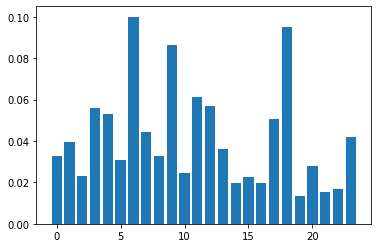

In [ ]:
importance = bst_classifier.feature_importances_
for i,v in enumerate(importance):
  print('Feature: %0d [%s], Score: %.5f' % (i,col_mi[i],v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
 with open('...', 'wb') as f: ##pickle file
        pickle.dump(bst_classifier, f)